<a href="https://colab.research.google.com/github/he1-m/Olmypics_data_analysis/blob/main/Olympics_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football Men's

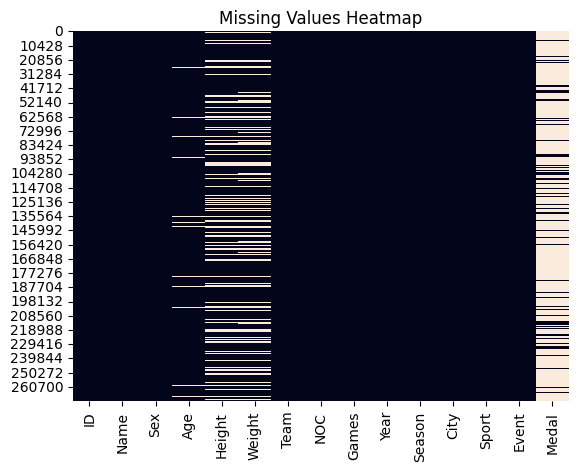

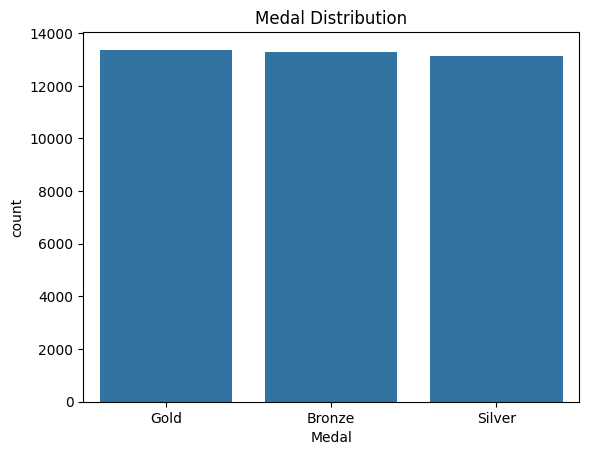

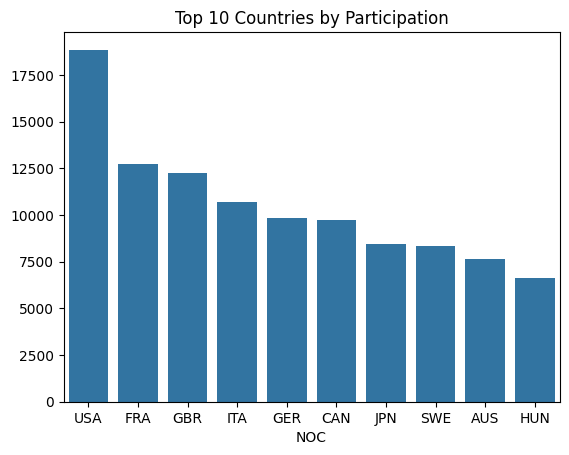

/tmp/ipython-input-1-2969805483.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-1-2969805483.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Accuracy: 0.8592136323399233
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.17      0.23      2659
           1       0.49      0.34      0.40      2675
           2       0.90      0.97      0.93     46267
           3       0.37      0.19      0.25      2623

    accuracy                           0.86     54224
   macro avg       0.52      0.42      0.45     54224
weighted avg       0.83      0.86      0.84     54224

Confusion Matrix:
 [[  448   178  1872   161]
 [  140   918  1400   217]
 [  564   496 44727   480]
 [  160   279  1687   497]]


/tmp/ipython-input-1-2969805483.py:104: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


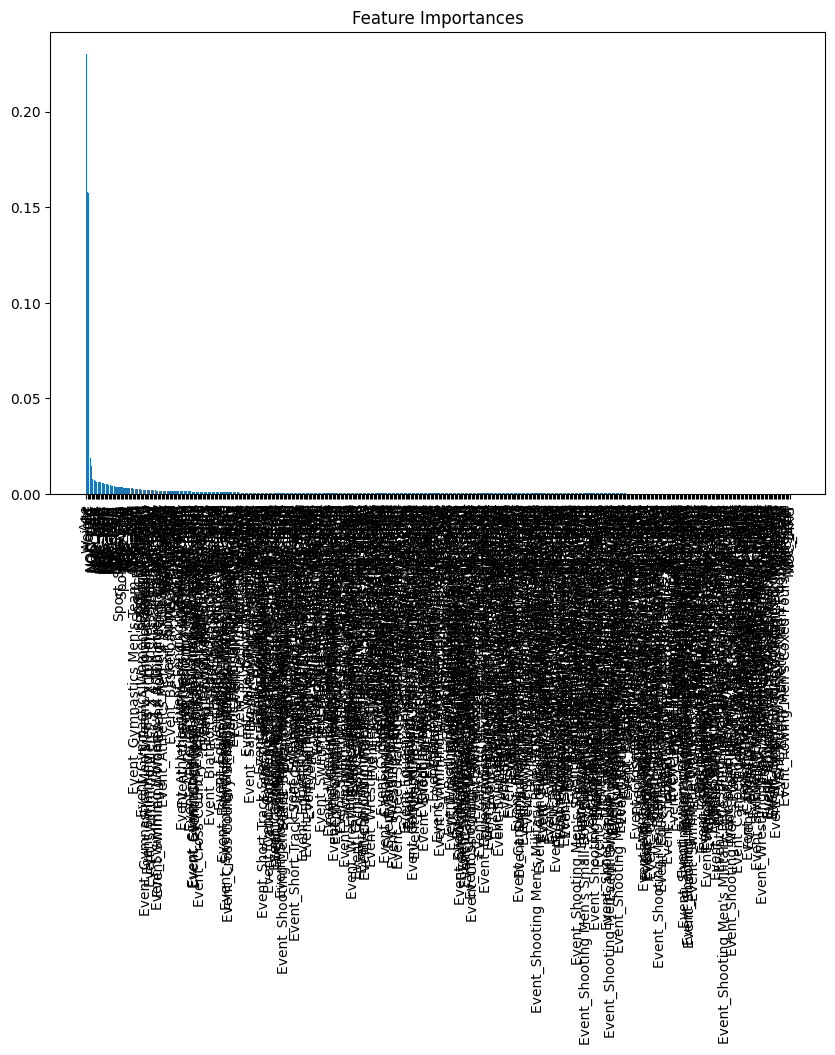

In [1]:
# Olympics Medal Prediction using Random Forest


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel


df = pd.read_csv('/content/athlete_events.csv (2).zip')

# 3. Exploratory Data Analysis (EDA)
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Visualize missing values
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

# Medal distribution
sns.countplot(x='Medal', data=df)
plt.title('Medal Distribution')
plt.show()

# Country performance
top_countries = df['NOC'].value_counts().head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Top 10 Countries by Participation')
plt.show()

# 4. Data Preprocessing

# Handle missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Height'].fillna(df['Height'].median(), inplace=True)
df['Weight'].fillna(df['Weight'].median(), inplace=True)
df['Medal'].fillna('None', inplace=True)

# Encode categorical variables
le_medal = LabelEncoder()
df['Medal'] = le_medal.fit_transform(df['Medal'])  # None=0, Bronze=1, Silver=2, Gold=3

le_sex = LabelEncoder()
df['Sex'] = le_sex.fit_transform(df['Sex'])

le_season = LabelEncoder()
df['Season'] = le_season.fit_transform(df['Season'])

# One-hot encode 'Sport' and 'Event'
df = pd.get_dummies(df, columns=['Sport', 'Event', 'NOC'], drop_first=True)

# 5. Feature Selection

# Select features for prediction
features = ['Age', 'Height', 'Weight', 'Sex', 'Season'] + \
           [col for col in df.columns if col.startswith('Sport_') or col.startswith('Event_') or col.startswith('NOC_')]
X = df[features]
y = df['Medal']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 7. Feature Importance with Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature selection based on importance
selector = SelectFromModel(rf, prefit=True, threshold='median')
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# 8. Model Training and Evaluation
rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_final.fit(X_train_selected, y_train)
y_pred = rf_final.predict(X_test_selected)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 9. Feature Importance Plot
importances = rf_final.feature_importances_
indices = np.argsort(importances)[::-1]
selected_features = np.array(features)[selector.get_support()]

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(selected_features)), importances[indices])
plt.xticks(range(len(selected_features)), selected_features[indices], rotation=90)
plt.tight_layout()
plt.show()
